In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

In [3]:
from backtesting import process_factors,neutralize_factors,ic_and_pnl

In [4]:
df_market = pd.read_parquet('../processed_market_data.parquet')

In [5]:
df_industry = pd.read_parquet('../industry.parquet')
df_industry['order_book_id'] = df_industry['order_book_id'].str[:6]

df_industry = pd.merge(df_market[['order_book_id','date']], df_industry, how = 'left')
df_industry['first_industry_code'] = df_industry['first_industry_code'].ffill()
df_industry.dropna(inplace=True)

df_industry = pd.get_dummies(df_industry, columns = ['first_industry_code'],prefix='industry')
df_industry = df_industry.astype({col: 'int' for col in df_industry.columns if col.startswith('industry_')})

## 尾盘UTD

In [6]:
df = pd.read_parquet('daily_turnover_vol_timesegment.parquet')

In [7]:
df3 = df[df['Time_seg']=='3']

In [8]:
df3['TurnVol_20_std'] = df3.groupby('order_book_id')['TurnVol_daily'].transform(lambda x: x.rolling(window=20).std())
df3['TurnVol_20_avg'] = df3.groupby('order_book_id')['TurnVol_daily'].transform(lambda x: x.rolling(window=20).mean())
df3['UTD'] = df3['TurnVol_20_std']/df3['TurnVol_20_avg']

In [9]:
df3['date'] = pd.to_datetime(df3['date'])
df3 = pd.merge(df3,df_market,on=['date','order_book_id'])

In [10]:
## 取负
df3['UTD'] = -df3['UTD'] 

In [11]:
df3 = process_factors(df3,factors= ['UTD'],process_method='rank')
df3 = neutralize_factors(df3, factors= ['UTD'], 
       market_factor=True,momentum_factor=True, industry_factor=True, df_industry = df_industry)

yes,it is rank
factor: UTD
Finish neutralize


##### 时间差分的UTD

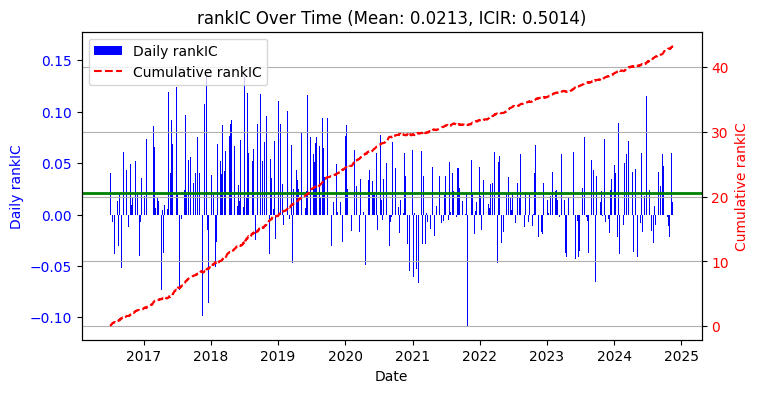

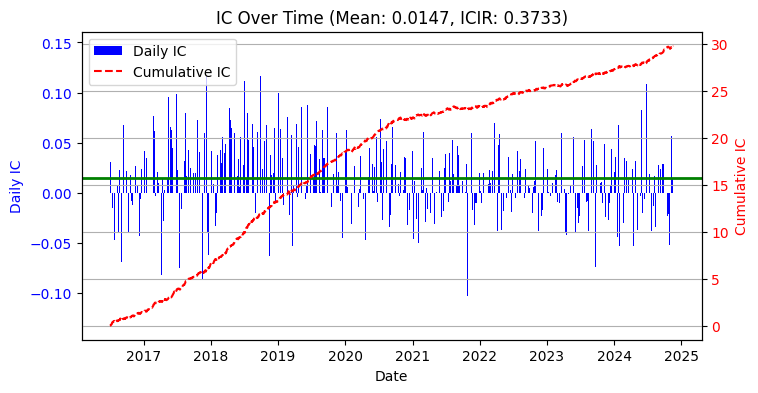

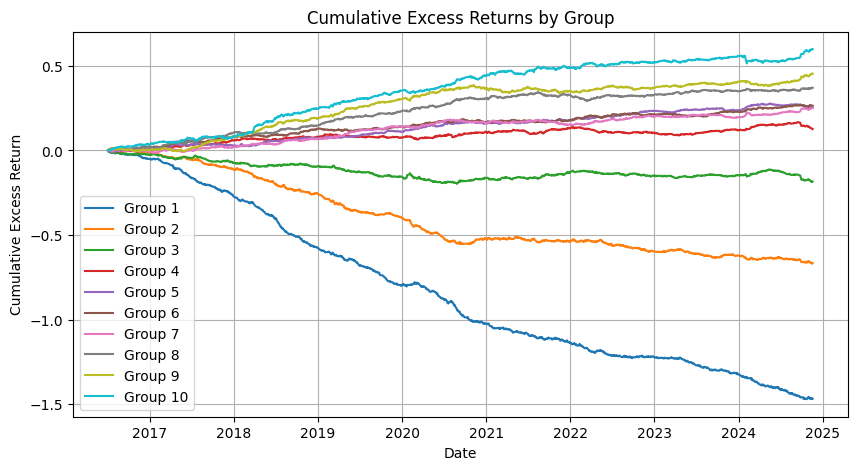

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0,-0.252360,-0.180514,-7.581118,-5.432951,0.239487
1,-0.221799,-0.081854,-7.055887,-2.606912,0.466482
2,-0.208139,-0.022676,-7.847191,-0.859293,0.618210
3,-0.206975,0.015527,-9.114453,0.690052,0.741672
4,-0.217352,0.031619,-10.663518,1.557969,0.829906
5,-0.231284,0.032534,-11.358343,1.606351,0.879396
6,-0.234022,0.030963,-11.200181,1.490069,0.883282
7,-0.205236,0.045541,-8.548115,1.904433,0.835922
8,-0.157185,0.055768,-5.649084,2.005896,0.709844


In [12]:
ic_and_pnl(df3,'neu_UTD_process')